In [27]:
#!pip install ecg-plot physionet_challenge_utility_script
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers import concatenate # Corrected import
from scipy import optimize
from scipy.io import loadmat
import os

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from zipfile import ZipFile
import os

In [30]:
from zipfile import ZipFile
import os

zip_file_path = '/content/drive/MyDrive/Training PBT /Training_PTB.zip'
file_path = []

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: Zip file not found at {zip_file_path}")
else:
    try:
        # Open the zip file
        with ZipFile(zip_file_path, 'r') as zip_ref:
            # Get a list of all files in the zip file
            file_list = zip_ref.namelist()

            # Print the list of files
            print("Files in the zip file:")
            for file in file_list:
                print(file)
                # If you want to store the file paths, you can append them here
                file_path.append(file)

    except Exception as e:
        print(f"An error occurred: {e}")

# Now file_path contains the list of files inside the zip
# You can process file_path further as needed

Files in the zip file:
Training_PTB/
__MACOSX/._Training_PTB
Training_PTB/S0143.hea
__MACOSX/Training_PTB/._S0143.hea
Training_PTB/S0113.mat
__MACOSX/Training_PTB/._S0113.mat
Training_PTB/S0107.mat
__MACOSX/Training_PTB/._S0107.mat
Training_PTB/S0157.hea
__MACOSX/Training_PTB/._S0157.hea
Training_PTB/S0180.hea
__MACOSX/Training_PTB/._S0180.hea
Training_PTB/S0194.hea
__MACOSX/Training_PTB/._S0194.hea
Training_PTB/S0369.hea
__MACOSX/Training_PTB/._S0369.hea
Training_PTB/S0311.mat
__MACOSX/Training_PTB/._S0311.mat
Training_PTB/S0427.hea
__MACOSX/Training_PTB/._S0427.hea
Training_PTB/S0341.hea
__MACOSX/Training_PTB/._S0341.hea
Training_PTB/S0477.mat
__MACOSX/Training_PTB/._S0477.mat
Training_PTB/S0463.mat
__MACOSX/Training_PTB/._S0463.mat
Training_PTB/S0355.hea
__MACOSX/Training_PTB/._S0355.hea
Training_PTB/S0433.hea
__MACOSX/Training_PTB/._S0433.hea
Training_PTB/S0305.mat
__MACOSX/Training_PTB/._S0305.mat
Training_PTB/S0488.mat
__MACOSX/Training_PTB/._S0488.mat
Training_PTB/S0382.hea
__MA

In [39]:
extract_path = '/content/ptb_data'  # You can change the folder name if you want

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete.")


✅ Extraction complete.


In [41]:
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [1]:
import os

data_dir = '/content/ptb_data'
files = os.listdir(data_dir)

# List a few files to check
print("Sample files:", files[:10])


Sample files: ['Training_PTB', '__MACOSX']


In [3]:
record_name = os.path.join('/content/ptb_data', 'Training_PTB', 'S0143')

In [7]:
import glob

hea_files = glob.glob(os.path.join(data_dir, '**/*.hea'), recursive=True)

signals = []
labels = []

for hea_file in hea_files:
    record_path = hea_file.replace('.hea', '')
    try:
        rec = wfdb.rdrecord(record_path)
        hdr = wfdb.rdheader(record_path)
        signals.append(rec.p_signal)
        labels.append(hdr.comments)  # or extract specific label if known format
    except Exception as e:
        print(f"Failed to read {record_path}: {e}")


In [8]:
import numpy as np
import pandas as pd

# Truncate or pad all signals to the same shape (e.g., 5000 samples)
signal_array = [s[:5000].flatten() if s.shape[0] >= 5000 else np.pad(s.flatten(), (0, 5000 - s.size)) for s in signals]

df = pd.DataFrame(signal_array)
df['label'] = labels
df.head()


,0,1,2,3,4,5,6,7,8,9,...,59991,59992,59993,59994,59995,59996,59997,59998,59999,label
0,-0.001017,-0.000929,0.000089,0.000973,-0.000553,-0.000420,-0.000367,-0.000399,-0.000508,-0.000436,...,0.000864,-0.000483,-0.000381,-0.000367,-0.000338,-0.000374,-0.000408,-0.000333,-0.000445,"[Age: 36, Sex: male, Dx: 426783006, Rx: Unknow..."
1,-0.000355,-0.000682,-0.000327,0.000518,-0.000014,-0.000504,0.000226,0.000077,0.000313,0.000212,...,0.000309,-0.000091,-0.000218,0.000069,-0.000030,0.000221,0.000069,-0.000029,0.000036,"[Age: 45, Sex: male, Dx: 164865005, Rx: Unknow..."
2,-0.000932,0.000218,0.001151,0.000357,-0.001042,0.000685,-0.000762,-0.000841,-0.000855,-0.000814,...,0.000396,-0.001015,0.000619,-0.000717,-0.000817,-0.000821,-0.000784,-0.000871,-0.000788,"[Age: 56, Sex: female, Dx: 164865005, Rx: Unkn..."
3,0.000287,0.000044,-0.000244,-0.000166,0.000266,-0.000100,0.000073,0.000277,-0.000006,-0.000058,...,-0.000351,0.000318,0.000034,0.000186,0.000532,0.000611,0.000776,0.000691,0.000532,"[Age: 64, Sex: female, Dx: 6374002, Rx: Unknow..."
4,-0.000124,0.000344,0.000469,-0.000110,-0.000296,0.000407,-0.000087,-0.000105,0.000088,0.000036,...,0.000139,-0.000093,-0.000046,0.000092,0.000064,0.000266,0.000045,-0.000063,0.000140,"[Age: 52, Sex: male, Dx: 164865005, Rx: Unknow..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Columns: 60001 entries, 0 to label
dtypes: float64(60000), object(1)
memory usage: 236.2+ MB


In [10]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,59990,59991,59992,59993,59994,59995,59996,59997,59998,59999
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,-0.000067,-0.000168,-0.000101,0.000118,0.000017,-0.000135,0.000028,0.000012,0.000033,-0.000005,...,-0.000092,0.000104,0.000017,-0.000121,0.000025,0.000007,0.000035,0.000003,-0.000034,-0.000044
std,0.000514,0.000729,0.000704,0.000524,0.000497,0.000669,0.000479,0.000474,0.000495,0.000517,...,0.000648,0.000486,0.000452,0.000622,0.000453,0.000434,0.000444,0.000471,0.000453,0.000445
min,-0.002694,-0.003058,-0.003293,-0.002031,-0.003079,-0.002838,-0.002406,-0.002109,-0.002291,-0.002425,...,-0.002825,-0.001824,-0.002486,-0.002469,-0.001917,-0.002073,-0.002211,-0.002704,-0.002158,-0.002446
25%,-0.000221,-0.000475,-0.000303,-0.000109,-0.000173,-0.000379,-0.000154,-0.000173,-0.000141,-0.000174,...,-0.000279,-0.000101,-0.000157,-0.000345,-0.000129,-0.000158,-0.000127,-0.000156,-0.000205,-0.000187
50%,-0.000017,-0.000101,-0.000068,0.000070,0.000012,-0.000100,0.000032,0.000020,0.000037,0.000008,...,-0.000060,0.000061,0.000002,-0.000086,0.000028,0.000013,0.000031,0.000019,-0.000024,-0.000021
75%,0.000137,0.000088,0.000134,0.000315,0.000220,0.000083,0.000204,0.000210,0.000236,0.000202,...,0.000130,0.000288,0.000200,0.000081,0.000208,0.000192,0.000222,0.000178,0.000147,0.000146
max,0.001669,0.002756,0.003732,0.002668,0.002103,0.002733,0.002004,0.002265,0.002394,0.003324,...,0.003044,0.002456,0.001897,0.002521,0.002227,0.001767,0.001940,0.003048,0.001607,0.001923


In [11]:
df.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
59996,0
59997,0
59998,0
59999,0


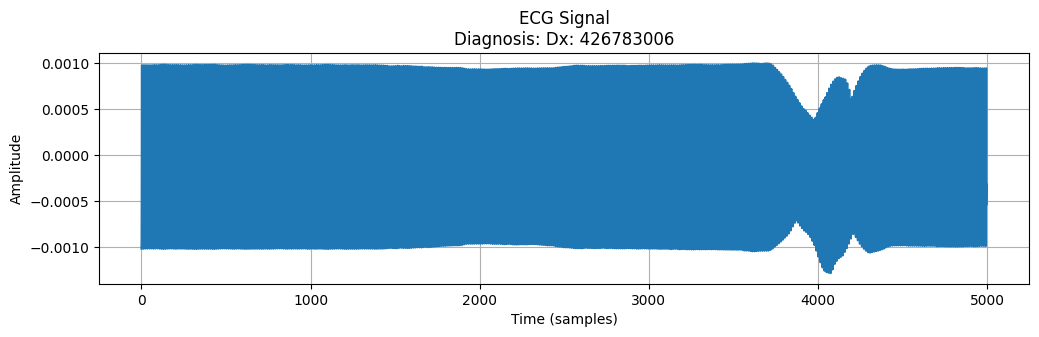

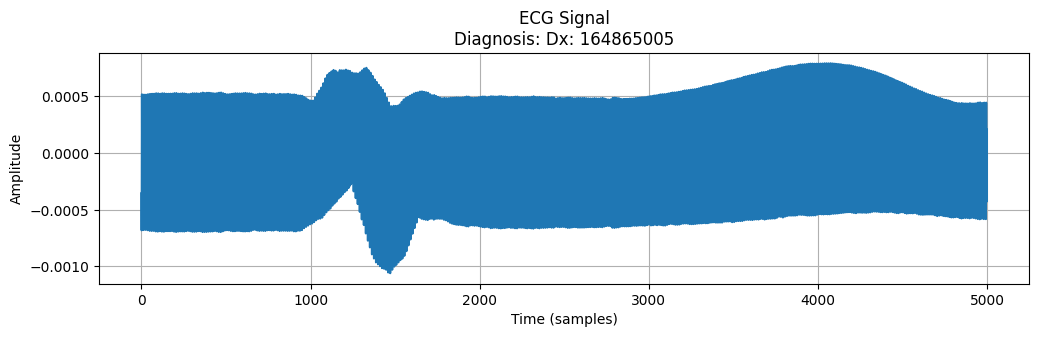

In [13]:
import matplotlib.pyplot as plt

# Plot first 2 ECG signals
for i in range(2):
    plt.figure(figsize=(12, 3))
    # Access signal data from numerical columns (assuming signal data is in columns 0 to 59999)
    # and the label from the 'label' column
    signal_data = df.iloc[i, :60000].values # Assuming signal data is in the first 60000 columns
    diagnosis_info = df.iloc[i]['label'] # Access the label from the 'label' column

    plt.plot(signal_data[:5000]) # Plotting the first 5000 samples as in the original code

    # Extract diagnosis if the label is a list of strings
    diagnosis_text = "Unknown Diagnosis"
    if isinstance(diagnosis_info, list):
        # Attempt to find a string containing 'Dx:'
        for item in diagnosis_info:
            if isinstance(item, str) and 'Dx:' in item:
                diagnosis_text = item
                break
        # If no 'Dx:' found, just join the list items
        if diagnosis_text == "Unknown Diagnosis" and diagnosis_info:
             diagnosis_text = ", ".join(map(str, diagnosis_info))
    elif isinstance(diagnosis_info, str):
         diagnosis_text = diagnosis_info


    # Note: We don't have the original filename readily available in the df DataFrame.
    # We will just display the diagnosis.
    plt.title(f"ECG Signal\nDiagnosis: {diagnosis_text}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Separate features (X) and labels (y)
# X will be all columns except 'label'
X = df.drop(columns=['label']).values
# y will be the extracted diagnosis codes
y = extracted_diagnoses # Use the extracted diagnoses here

# Handle potential None values if any diagnoses couldn't be extracted
# For now, we'll drop rows where diagnosis extraction failed.
# You might want to handle these differently depending on your data.
valid_indices = y.notnull()
X = X[valid_indices]
y = y[valid_indices]


# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_onehot: {y_onehot.shape}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")

Shape of X_train: (412, 60000)
Shape of y_train: (412, 15)
Shape of y_onehot: (516, 15)
Number of unique classes: 15


In [16]:
import re

def extract_diagnosis(label_list):
    """Extracts the diagnosis code from a list of label strings."""
    if isinstance(label_list, list):
        for item in label_list:
            if isinstance(item, str):
                match = re.search(r'Dx: (\d+)', item)
                if match:
                    return match.group(1)
    return None # Return None if diagnosis is not found

# Apply the extraction function to the 'label' column
extracted_diagnoses = df['label'].apply(extract_diagnosis)

# Check the first few extracted diagnoses
print("First few extracted diagnoses:")
print(extracted_diagnoses.head())

# Check for any records where diagnosis extraction failed
if extracted_diagnoses.isnull().any():
    print("\nWarning: Some diagnoses could not be extracted.")
    print(extracted_diagnoses[extracted_diagnoses.isnull()])

First few extracted diagnoses:
0    426783006
1    164865005
2    164865005
3      6374002
4    164865005
Name: label, dtype: object


In [18]:
# Reshape from (n_samples, 5000) → (n_samples, 5000, 1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 59996, 32)      │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29998, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29998, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 29996, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14998, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14998, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 959872)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    61,431,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,439,247 (234.37 MB)

 Trainable params: 61,439,247 (234.37 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.5180 - loss: 2.0002 - val_accuracy: 0.5673 - val_loss: 1.9066
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.6285 - loss: 1.6334 - val_accuracy: 0.5673 - val_loss: 1.6866
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.6669 - loss: 1.4284 - val_accuracy: 0.5673 - val_loss: 1.6837
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6645 - loss: 1.5063 - val_accuracy: 0.5673 - val_loss: 1.6339
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6591 - loss: 1.4098 - val_accuracy: 0.5673 - val_loss: 1.6471
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.6495 - loss: 1.4635 - val_accuracy: 0.5673 - val_loss: 1.5990
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.6476 - loss: 1.3960 - val_accuracy: 0.5673 - val_loss: 1.6205
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.6227 - loss: 1.4547 - val_accuracy: 0.5673 - val_loss:

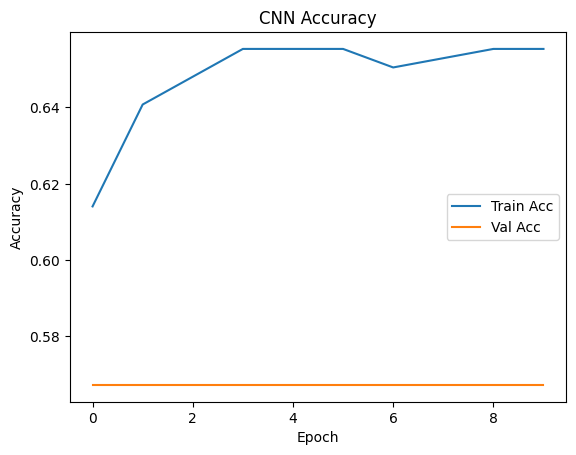

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 859ms/step - accuracy: 0.5582 - loss: 1.5502
CNN Test Accuracy: 0.5673


In [21]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluate on test data
loss, acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Test Accuracy: {acc:.4f}")
